# Explore here

It's recommended to use this notebook for exploration purposes.

In [33]:
# Step 1: Install dependencies

import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Step 2: Download the full HTML from the url

resource_url = "https://ycharts.com/companies/TSLA/revenues"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

time.sleep(4)

response = requests.get(resource_url, headers=headers)


if response.status_code == 200:
    with open("revenues.html", "wb") as dataset:
      dataset.write(response.content) 
    print("HTML content downloaded successfully.")
else:
    print(f"Request failed with status code: {response.status_code}")


HTML content downloaded successfully.


In [10]:
# Step 3. A) Transform the HTML (Just fetching last 4 years revenue data)

# openning and reading the downloaded content, turning it into a string before transforming it with BeautifulSoup
with open("revenues.html", "r", encoding ="utf-8") as file: # 'utf-8' is common but may need adjustment
  html_content = file.read()

# Turning the downloaded content into html identifying it as a BeautifulSoup object (transforming the scrapped content of previous steff into clean html)

soup = BeautifulSoup(html_content, "html.parser")



In [ ]:
#Step 3.B) Find the table with the quarterly evolution

#Identify and target in the url the specific html content we are interested in (Tesla quarterly revenue table): 
#<div class="panel panel-data"><div class="panel-header"><h3 class="panel-title">Revenue (Quarterly) Chart</h3>

soup_html = soup.find("div", class_="panel panel-data").find("div", class_="panel-header").find("h3", class_="panel-title")

#Confirm if the element (revenue table) has been found
if soup_html:
  print("Quarterly revenue table found!")
else: print("Quarterly revenue table not found :'(. Check html search criteria")

# IMPORTANT: The `<h3>` element itself does not contain the data requested, it just points to where it is 
# Using `find_next('table')` to locate a nearby `<table>` element that likely holds the actual revenue data.

revenues = soup_html.find_next("table")


Quarterly revenue table found!


In [5]:
# Step 4) Process the DataFrame

#Fetching and cleaning the data (content of the table) in a visual way by turning into a dataframe

import pandas as pd

dates = [] 
values = [] 

for row in revenues.find_all("tr"): 
  cells = row.find_all('td') 
  if len(cells) >= 2: #Check if the rows has at least 2 cells (for Dates and Values)
    #using text.strip() to get clean data without $, comas, or other signs
    dates.append(cells[0].text.strip())  # Since the "Value" column initially printed "..." instead of amounts, making sure I extract and clean the date using text.strip()
    
    # Find the specific element containing the value 
    value_element = row.find("td", class_="text-right") #taken from one revenue value html by inspecting element

    if value_element:
      values.append(value_element.text.strip()) # Extract and clean the value element (since it initally appeared as "..." instead of values)
    else: 
      values.append("N/A") # Handle cases where the value element is not found

# Create a dictionary with the extracted data to make it easier to turn into dataframe
data = {"Dates": dates, "Values": values}

# Create the Pandas DataFrame
revenues_df = pd.DataFrame(data)

# Data cleanse triple check 
# by removing empty cells or NaN
revenues_df.dropna(subset=["Dates", "Values"], inplace=True)
# Removing rows with empty strings in "Values"
revenues_df = revenues_df[revenues_df["Values"] != ''] 
# Remove rows with only whitespace in "Values"
revenues_df = revenues_df[revenues_df["Values"].str.strip() != '']  

# Checking it there are NaN 
if revenues_df.isna().any().any() == False:
  print("no NaN found")
else:
  print("There are NaN")

print(revenues_df)
print(revenues_df.columns)
print(revenues_df.index)

if type(revenues_df) == pd.core.frame.DataFrame:
    print("revenues_df is a DataFrame")
else:
    print("revenues_df is not a DataFrame")

no NaN found
                 Dates  Values
0   September 30, 2024  25.18B
1        June 30, 2024  25.50B
2       March 31, 2024  21.30B
3    December 31, 2023  25.17B
4   September 30, 2023  23.35B
5        June 30, 2023  24.93B
6       March 31, 2023  23.33B
7    December 31, 2022  24.32B
8   September 30, 2022  21.45B
9        June 30, 2022  16.93B
10      March 31, 2022  18.76B
11   December 31, 2021  17.72B
12  September 30, 2021  13.76B
13       June 30, 2021  11.96B
14      March 31, 2021  10.39B
15   December 31, 2020  10.74B
16  September 30, 2020  8.771B
17       June 30, 2020  6.036B
18      March 31, 2020  5.985B
19   December 31, 2019  7.384B
20  September 30, 2019  6.303B
21       June 30, 2019   6.35B
22      March 31, 2019  4.541B
23   December 31, 2018  7.226B
24  September 30, 2018  6.824B
Index(['Dates', 'Values'], dtype='object')
RangeIndex(start=0, stop=25, step=1)
revenues_df is a DataFrame


In [ ]:
## Step 5: Store the data in sqlite
import sqlite3
import pandas as pd


# Connect to the database or create it if it doesn't exist
con = sqlite3.connect("revenues.db") #This data document is already created and stored in this github/workspaces/web-scraping-project-tutorialDianaM/src/revenues.db

con.commit()


#CREATE: Generate a table named QUARTERLY REVENUES with 2 columns: DATES AND VALUES
con.execute("""CREATE TABLE IF NOT EXISTS REVENUES(
    DATES TEXT NOT NULL PRIMARY KEY,  -- Changed DATES to TEXT
    REVENUE TEXT NOT NULL            -- Changed REVENUE to TEXT
)""")

# Include the clean data in it, as we saw in the database module.

# This query defines the operation of inserting data into the specified columns (DATES, REVENUE) of the table (QUARTERLY_REVENUES). 
# The placeholders (?) will be filled with values from the DataFrame. 

insert_query = "INSERT OR IGNORE INTO REVENUES (DATES, REVENUE) VALUES (?, ?)" 

# Iterate Through DataFrame Rows and Execute INSERT

for index, row in revenues_df.iterrows():
    con.execute(insert_query, (row["Dates"], row["Values"]))
con.commit()


In [ ]:
#Visualizing the sqlite table:

cursor = con.execute("SELECT * FROM REVENUES")
for row in cursor:
    print(f"Dates = {row[0]} Reveneu = {row[1]}")


Dates = September 30, 2024 Reveneu = 25.18B
Dates = June 30, 2024 Reveneu = 25.50B
Dates = March 31, 2024 Reveneu = 21.30B
Dates = December 31, 2023 Reveneu = 25.17B
Dates = September 30, 2023 Reveneu = 23.35B
Dates = June 30, 2023 Reveneu = 24.93B
Dates = March 31, 2023 Reveneu = 23.33B
Dates = December 31, 2022 Reveneu = 24.32B
Dates = September 30, 2022 Reveneu = 21.45B
Dates = June 30, 2022 Reveneu = 16.93B
Dates = March 31, 2022 Reveneu = 18.76B
Dates = December 31, 2021 Reveneu = 17.72B
Dates = September 30, 2021 Reveneu = 13.76B
Dates = June 30, 2021 Reveneu = 11.96B
Dates = March 31, 2021 Reveneu = 10.39B
Dates = December 31, 2020 Reveneu = 10.74B
Dates = September 30, 2020 Reveneu = 8.771B
Dates = June 30, 2020 Reveneu = 6.036B
Dates = March 31, 2020 Reveneu = 5.985B
Dates = December 31, 2019 Reveneu = 7.384B
Dates = September 30, 2019 Reveneu = 6.303B
Dates = June 30, 2019 Reveneu = 6.35B
Dates = March 31, 2019 Reveneu = 4.541B
Dates = December 31, 2018 Reveneu = 7.226B
Dates

/tmp/ipykernel_627/479736277.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


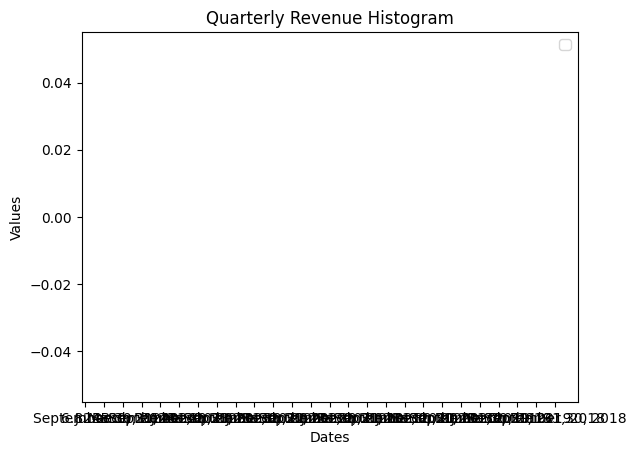

In [42]:
# Step 6: Visualize the data. What types of visualizations can we make? 
# Suggest at least 3 and plot them.


reveneus_string = revenues_df["Values"]
dates_string = revenues_df["Dates"]

reveneus_list = list(map(str, reveneus_string))
dates_list = list(map(str, dates_string))

x = reveneus_list
y = dates_list

plt.hist(x, y)

plt.title("Quarterly Revenue Histogram")
plt.xlabel("Dates")
plt.ylabel("Values")
plt.legend()
plt.show()

